# Nilearn connectome plotting: use cases and changes suggestions
Here, we present typical usage of connectome plotting functions together with some problems with the current implementations. We also make suggestions how to simplify connectome plotting functions and make them more accessible to users. 

## Load datasets

In [1]:
from nilearn import datasets

dataset = datasets.fetch_development_fmri(n_subjects=1)
power = datasets.fetch_coords_power_2011()

## Extract signals from parcellation

In [2]:
import numpy as np
from nilearn import input_data

coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords,
    smoothing_fwhm=6, 
    radius=5.,
    detrend=True, 
    standardize=True, 
    low_pass=0.1, 
    high_pass=0.01, 
    t_r=2
)

func_filename = dataset.func[0]
confounds_filename = dataset.confounds[0]

timeseries = spheres_masker.fit_transform(func_filename,
                                          confounds=confounds_filename)

print(timeseries.shape)

(168, 264)


## Calculate connectivity

In [3]:
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

connectivity_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = connectivity_measure.fit_transform([timeseries])[0]

## Plot connectivity matrix

#### Regular use of `plot_connectome`

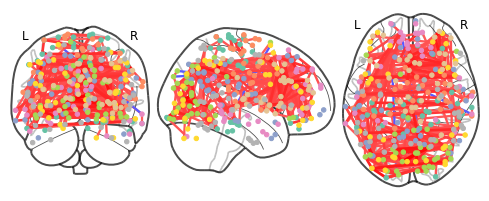

In [4]:
plotting.plot_connectome(
    correlation_matrix, 
    node_coords=coords,
    edge_threshold='98.8%',
    node_size=20,
)

From the user perspective these things could be changed or improved:

1. Default behavior of `node_color='auto'` is misleading, since it creates arbitrary colors for different nodes suggesting some kind of network division, or other information that user did not provide. Also, default `'auto'` option is not described in the documentation. Default option should create uniformly colored nodes (e.g. gray). 

2. Behavior of `edge_threshold` argument passed as a string representation of percentile is sligtly counterintuitive considering common practice to report threshold as percentage of strongest edges, i.e. 5% threshold would retain 5% of strongest edges not 95% strongest edges.

3. Parameter `alpha` seems to have no effect on resulting plot.

#### Using `plot_connectome` to represent only network nodes

You can also easlily use `plot_connectome` to plot nodes of the network by setting `adjacency_matrix` to array of zeros (size should be the same as the original). Note that such use case causes an error when with `colorbar=True`, but the error message is not helpful for the user (see below). Perhaps it would be more staightforward to allow the user to specify `adjacency_matric=None`.

Error message: 'GlassBrainAxes' object has no attribute 'cmap'


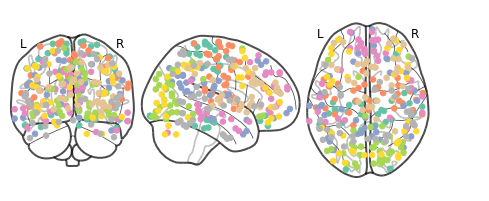

In [5]:
try:
    plotting.plot_connectome(
        np.zeros(correlation_matrix.shape), 
        coords, 
        node_size=30, 
        colorbar=True
    )
except AttributeError as ex:
    print(f'Error message: {ex}')

Users often need to color code their nodes according to some specific nodal measure – usually centrality measure like e.g. node strength. It is quite simple to adapt `plot_connectome` function to acheive this result.

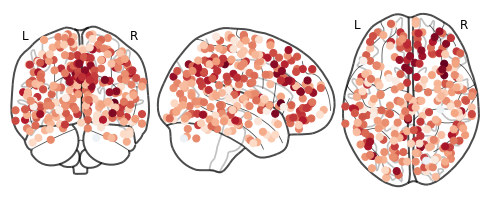

In [6]:
import matplotlib

# Calculate nodal measure
node_strenght = np.sum(np.abs(correlation_matrix), axis=0)
node_strenght = node_strenght / np.max(node_strenght)

cmap = matplotlib.cm.get_cmap('RdBu_r')

plotting.plot_connectome(
    np.zeros(correlation_matrix.shape), 
    coords, 
    node_color=[cmap(s) for s in node_strenght]
)

This approach works as expected – nodes with higher absolute connection strenght are darker red. One drawback is that it is not easy to create colorbar for nodal colormap (`colorbar` argument reflects edge colormap). There is another function in the `plotting` module – `plot_connectome_strength` – which apparently provides same funcionality (it color code nodes according to automatically calculated node strenght). 

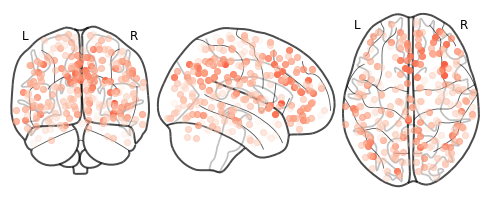

In [7]:
plotting.plot_connectome_strength(
    correlation_matrix,
    coords,
    cmap='Reds'
)

Major issue related to this function:

1. It has two different functionalities: calculating nodal strength and plotting network nodes on top of the brain schematics. User has no control over centrality measure used to color code nodes – e.g. it is impossible to use another nodal measure or treat negative connections in another way. Function seems to be very specific and it is not easily adaptable for user needs. Since the same functionality can be easily acheived using `plot_connectome` function adding few extra lines of code `plot_connectome_strenght` smells like a feature creep.

There are several other issues related to this function:

2. Function focuses on providing color representation of node strenght but does not offer the user option to easily include colorbar or limits for colormap (similar function `plot_connectome` has arguments `colobar`, `edge_vmin` and `edge_vmax`), which makes it impractical for scientific use. 

3. Name of the function is misleading, because connectome (network edges) is not plotted. More appropriate name would be `plot_node_strenght`. 

4. `node_size` argument should also accept array-like object of individual node size like `plot_connectome` function. Documentation, however specified that only `auto` and scalar are possible argument values. Function currently doesn't raise TypeError when array-like object is provided, instead first element of the array is used (it is a bug, *see below*).

5. It is not straightforward to control node transparency which may be desirable.

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:1378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_size == 'auto' else node_size)


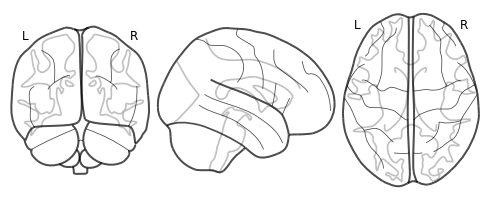

In [8]:
node_size = np.random.random(len(coords)) * 50
node_size[0] = 0

plotting.plot_connectome_strength(
    correlation_matrix,
    coords,
    cmap='Reds',
    node_size=node_size
)

### Our general suggestion is to remove the function `plot_connectome_strenght` and to add a simple example how to acheive the same effect using `plot_connectome` instead. 